## Load Python Libraries

In [82]:
import torch
from torchvision import transforms
import torchvision.models as models
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Subset, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

from scipy.stats import pearsonr
from PIL import Image

## Linear Model

In [83]:
# Define model
class Linear_NN(torch.nn.Module):

    # 180 is given from the one-hot encoding of the 20 amino acids * 9 peptide length
    def __init__(self, input_size):
        super(Linear_NN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, input_size // 2)
        self.fc2 = torch.nn.Linear(input_size//2, input_size // 10)
        self.fc3 = torch.nn.Linear(input_size//10, 1)
        self.drop = torch.nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.drop(x)
        out = self.fc3(x)
        return out

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Recurrent Neural Network

In [84]:
class RNN(torch.nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        
        # Define the RNN layer
        # Batch first means that the input and output tensors are provided as (batch, seq, feature)
        # num_layers is the number of stacked RNN layers
        self.rnn = torch.nn.RNN(input_size, hidden_size = 64, num_layers = 2, batch_first=True, nonlinearity='relu')
        
        # Define the fully connected layer
        self.fc = torch.nn.Linear(64, 1)

    def forward(self, x):

        h0 = torch.zeros(2, x.size(0), 64).to(device)

        # Forward pass
        out, _ = self.rnn(x, h0)
        # Output shape = (batch_size, seq_length, hidden_size)
        # -1 means the last element of the sequence
        out = self.fc(out[:, -1, :])
        return out

## Get a list of peptides

In [85]:
peptide_score_file = './data/training_peptide_PSSM_scores.txt'

def load_peptide_data(infile):

    peptides = list()
    PSSM_score = list()

    with open(infile) as f:
        for line in f:
            peptide, score = line.strip().split()
            peptides.append(list(peptide))
            PSSM_score.append(float(score))

    return peptides, PSSM_score

peptides, PSSM_score = load_peptide_data(peptide_score_file)

## One-hot encoding of the pepetides

In [86]:
def one_hot_encode_peptides(peptides, flatten = True):

    flattened_peptides = np.array(peptides).flatten().reshape(-1, 1)

    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(categories=[list('ACDEFGHIKLMNPQRSTVWY')], sparse_output=False)

    # Transform the peptide sequences into a one-hot encoded format
    one_hot_encoded = encoder.fit_transform(flattened_peptides)

    
    num_peptides = len(peptides)
    
    if flatten:
        # Reshape back into the original peptide sequence format
        one_hot_encoded = one_hot_encoded.reshape(num_peptides, -1)
        
        return one_hot_encoded

    one_hot_encoded = one_hot_encoded.reshape(num_peptides, len(peptides[0]), -1)

    return one_hot_encoded

## PCA-reduced Pixel encoding

In [87]:
amino_acid_full_names = {
    'A': 'alanine', 'R': 'arginine', 'N': 'asparagine', 'D': 'aspartic_acid', 'C': 'cysteine', 
    'E': 'glutamic_acid', 'Q': 'glutamine', 'G': 'glycine', 'H': 'histidine', 'I': 'isoleucine', 
    'L': 'leucine', 'K': 'lysine', 'M': 'methionine', 'F': 'phenylalanine', 'P': 'proline',
    'S': 'serine', 'T': 'threonine', 'W': 'tryptophan', 'Y': 'tyrosine', 'V': 'valine'
}

### Load amino acid depictions

In [88]:
#store images in cache to save performance
image_cache = {}

def load_AA_image(img_path, vgg = True):

    if img_path in image_cache:
        return image_cache[img_path]
    
    # Define transformation to do on image
    
    # Maybe not do it, if vgg is not the method
    if vgg:
        transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        transform = transforms.Compose([transforms.ToTensor()])

    image = Image.open(img_path).convert('RGB')
    processed_image = transform(image).unsqueeze(0).to(device)
    
    image_cache[img_path] = processed_image
    
    return processed_image

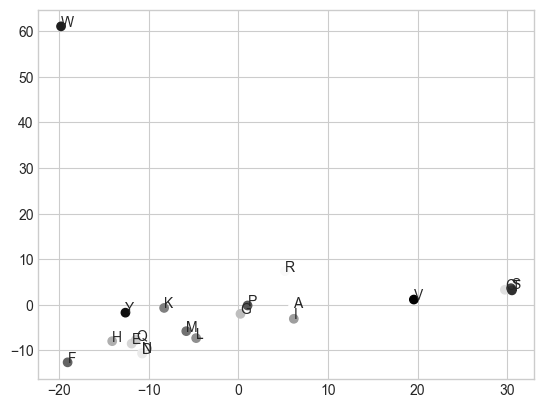

In [89]:
features = []

for letter, aa in amino_acid_full_names.items():
        # load and preprocess
        img_path = f'./2Dstruc/{aa}.png'
        image = load_AA_image(img_path, vgg = False)
        features.append(image.flatten())


features = torch.cat(features, dim=0).reshape(20, -1).to(device)

pca = PCA(random_state=42, n_components=2)
X = pca.fit_transform(features.cpu().numpy())
plt.scatter(X[:, 0], X[:, 1], c = range(20))
for i, txt in enumerate(amino_acid_full_names.keys()):
    plt.annotate(txt, (X[i, 0], X[i, 1]))

In [90]:
def PCA_pixel_features(amino_acid_full_names, reduce_dim = True):
    
    pixel_features = []

    for letter, aa in amino_acid_full_names.items():
        # load and preprocess
        img_path = f'./2Dstruc/{aa}.png'
        image = load_AA_image(img_path, vgg = False)
        pixel_features.append(image.flatten())

    pixel_features = np.vstack(pixel_features)

    if reduce_dim:

        # PCA
        pca = PCA(random_state=42)
        pixel_features = pca.fit_transform(pixel_features)

        aa_features_dict = {}
        for idx, aa in enumerate(amino_acid_full_names.keys()):
            aa_features_dict[aa] = pixel_features[idx, :]

        return aa_features_dict, pca
    

    # Create dictionary with aa_name:PCA_feature
    aa_features_dict = {}
    for idx, aa in enumerate(amino_acid_full_names.keys()):
        aa_features_dict[aa] = pixel_features[idx, :]

    return aa_features_dict

In [91]:
def plot_PCA_variance(pca, encoding_method, cumulative=True):
    # Assuming you have already performed PCA and stored it in the variable 'pca'
    variance_ratio = pca.explained_variance_ratio_

    if cumulative:
        cumulative_variance = np.cumsum(variance_ratio)
        plt.figure()
        plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, '*-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Variance')
        plt.title('Cumulative Variance by Number of Components, Encoding Method: ' + encoding_method)
        plt.show()
    else:
        plt.figure()
        plt.bar(range(1, len(variance_ratio)+1), variance_ratio)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance Ratio')
        plt.title('Variance Ratio by Number of Components, Encoding Method: ' + encoding_method)
        plt.show()
    

## VGG16 transformation

In [92]:
def vgg_features(amino_acid_full_names, reduce_dim = True):

    # Define VGG model
    vgg16_bn = torch.nn.Sequential(   
    # Use only the convolutionary part
    models.vgg16_bn(pretrained = True).features,
    torch.nn.Flatten()
    )

    vgg16 = vgg16_bn.to(device)
    vgg16.eval()

    vgg_features = []

    for aa in amino_acid_full_names.values():
        # load and preprocess
        img_path = f'./2Dstruc/{aa}.png'
        image = load_AA_image(img_path)

        # Disable gradient calculation
        with torch.no_grad():
            conv_features = vgg16(image)

        vgg_features.append(conv_features.cpu().numpy())

    vgg_features = np.vstack(vgg_features)

    if reduce_dim:

        pca = PCA(random_state=42)
        vgg_features = pca.fit_transform(vgg_features)
        
        aa_features_dict = {}
        for idx, aa in enumerate(amino_acid_full_names.keys()):
            aa_features_dict[aa] = vgg_features[idx, :]

        return aa_features_dict, pca

    # Create dictionary with aa_name:PCA_feature
    aa_features_dict = {}
    for idx, aa in enumerate(amino_acid_full_names.keys()):
        aa_features_dict[aa] = vgg_features[idx, :]

    return aa_features_dict

## ResNet50

In [93]:
def resnet50_feature_extractor(amino_acid_full_names):
    resnet50 = models.resnet50(pretrained=True)
    feature_extractor = torch.nn.Sequential(*list(resnet50.children())[:-1]).to(device)

    feature_extractor.eval()
    
    resnet50_features = {}

    for letter, aa in amino_acid_full_names.items():
        # load and preprocess
        img_path = f'./2Dstruc/{aa}.png'
        image = load_AA_image(img_path)
        with torch.no_grad():
            feature = feature_extractor(image)
            resnet50_features[letter] = feature.cpu().numpy().flatten()
    
    return resnet50_features

## Peptide data encoding

In [94]:
def Encoder(peptides, aa_features_dict, flatten = True):
    
    encoded_peptides = []

    for peptide in peptides:
        encoded_peptide = []
    
        for aa in peptide:
            encoded_peptide.append(aa_features_dict[aa])
        
        if flatten:
            encoded_peptide = np.array(encoded_peptide).flatten()
        
        encoded_peptides.append(encoded_peptide)

    return np.array(encoded_peptides)

In [95]:
encoding_method = 'resnet50' # onehot, pca, vgg, resnet50
network_type = 'linear' # linear, rnn
reduce_dim = False

# If input need to be flattened
if network_type == 'linear':
    flatten = True
else:
    flatten = False


# Encode method
if encoding_method == 'onehot':
    encoded_peptides = one_hot_encode_peptides(peptides, flatten=flatten)

elif encoding_method == 'pca':
    if reduce_dim:
        aa_feature_dict, pca = PCA_pixel_features(amino_acid_full_names, reduce_dim=reduce_dim)
    else:
        aa_feature_dict = PCA_pixel_features(amino_acid_full_names, reduce_dim=reduce_dim)
    
    encoded_peptides = Encoder(peptides, aa_feature_dict, flatten=flatten)

elif encoding_method == 'vgg':
    if reduce_dim:
        aa_feature_dict, pca = vgg_features(amino_acid_full_names, reduce_dim=reduce_dim)
    else:   
        aa_feature_dict = vgg_features(amino_acid_full_names, reduce_dim=reduce_dim)
    
    encoded_peptides = Encoder(peptides, aa_feature_dict, flatten=flatten)

elif encoding_method == 'resnet50':
    aa_feature_dict = resnet50_feature_extractor(amino_acid_full_names)
    encoded_peptides = Encoder(peptides, aa_feature_dict, flatten=flatten)

# If PCA is applied
if reduce_dim:
    plot_PCA_variance(pca, encoding_method, cumulative=True)
  
if network_type == 'linear':
    input_size = encoded_peptides[0].shape[0]
else:
    input_size = encoded_peptides[0].shape[1]

print(input_size)

C:\Users\Chuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Chuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


18432


## Define function to reset weight
Weight resetting aid to prevent the weight leakage

In [96]:
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        print(f'reset weight of layer {m}')
        m.reset_parameters()

### Loss function and optimizer

In [97]:
# Define the loss function 
criterion = torch.nn.MSELoss()

In [98]:
peptides_tensor = torch.tensor(encoded_peptides, dtype=torch.float32).to(device)
PSSM_score_tensor = torch.tensor(np.asarray(PSSM_score).reshape(-1,1), dtype=torch.float32).to(device)

peptides_dataset = TensorDataset(peptides_tensor, PSSM_score_tensor)

## Train model

In [99]:
def plot_loss(train_loss, val_loss, fold, encoding_method):
    plt.figure()
    plt.plot(train_loss, label='train err')
    plt.plot(val_loss, label='val err')
    plt.legend()
    plt.yscale('log')
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f'./loss/{network_type}/{encoding_method}_loss_fold_{fold}.png')
    plt.close()

In [100]:
torch.manual_seed(69)

kfold = KFold(n_splits=5, shuffle=True, random_state=69)

print("Starting KFold Cross Validation")

for fold, (train_ids, test_ids) in enumerate(kfold.split(peptides_dataset), 1):
    
    print(f'Fold {fold}')

    # Shuffle the data
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    # Define the data loaders
    train_loader = DataLoader(peptides_dataset, batch_size=10, sampler=train_subsampler)
    test_loader = DataLoader(peptides_dataset, batch_size=10, sampler=test_subsampler)

    # Initialize NN
    if network_type == 'linear':
        model = Linear_NN(input_size).to(device)
    
    elif network_type == 'rnn':
        model = RNN(input_size).to(device)

    model.apply(reset_weights)


    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    training_losses = []
    validation_losses = []

    for epoch in range(0, 100):
    
            print(f'Epoch {epoch+1}')

            training_loss = 0.0

            for i, data in enumerate(train_loader):
                  
                # Get the inputs
                inputs, labels = data

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                if network_type == 'rnn':
                    inputs = inputs.view(-1, len(peptides[0]), input_size)

                outputs = model(inputs)

                # Calculate the loss
                loss = criterion(outputs, labels)

                # Backward pass
                loss.backward()

                # Optimize
                optimizer.step()

                training_loss += loss.item()
            
            with torch.no_grad():
                model.eval()
                validation_loss = 0.0

                for inputs, labels in test_loader:

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    validation_loss += loss.item()

            training_losses.append(training_loss/len(train_loader))
            validation_losses.append(validation_loss/len(test_loader))

            print(f'Training loss: {training_loss/len(train_loader)}')
            print(f'Validation Loss: {validation_loss/len(test_loader)}')

            
    # Save the model
    print('Finished Training, Saving Model')
    torch.save(model.state_dict(), f'./model/{network_type}/{encoding_method}_model_fold_{fold}.pt')

    # Plot the loss
    plot_loss(training_losses, validation_losses, fold, encoding_method) 
  
    

Starting KFold Cross Validation
Fold 1
reset weight of layer Linear(in_features=18432, out_features=9216, bias=True)
reset weight of layer Linear(in_features=9216, out_features=1843, bias=True)
reset weight of layer Linear(in_features=1843, out_features=1, bias=True)
Epoch 1
Training loss: 45.82859837640192
Validation Loss: 21.50148871421814
Epoch 2


KeyboardInterrupt: 

: 

## Evaluating the model with unseen data

In [ ]:
evaluation_data = f'./data/evaluation_peptide_PSSM_scores.txt'
# evaluation_data = '../data/data/PSSM/A0201.eval'
evaluation_peptides, evaluation_score = load_peptide_data(evaluation_data)

if encoding_method == 'onehot':
    encoded_evaluation_peptides = one_hot_encode_peptides(evaluation_peptides, flatten=flatten)
else:
    encoded_evaluation_peptides = Encoder(evaluation_peptides, aa_feature_dict, flatten=flatten)

# Convert to tensors
evaluation_peptides_tensor = torch.tensor(encoded_evaluation_peptides, dtype=torch.float32).to(device)
evaluation_score_tensor = torch.tensor(np.asarray(evaluation_score).reshape(-1,1), dtype=torch.float32).to(device)

evaluation_peptides_dataset = TensorDataset(evaluation_peptides_tensor, evaluation_score_tensor)


def evaluate_model(models, evaluation_peptides_dataset):
    predictions = []

    evaluation_data_loader = DataLoader(evaluation_peptides_dataset, batch_size=10)

    with torch.no_grad():
        for model in models:
            model.eval()
            model_predictions = []

            for peptides, _ in evaluation_data_loader:
                peptides = peptides.to(device)
                outputs = model(peptides)
                model_predictions.extend(outputs.cpu().numpy())

            predictions.append(model_predictions)

    # Average predictions across models
    averaged_predictions = np.mean(predictions, axis=0)

    # Calculate total loss
    total_loss = criterion(torch.tensor(averaged_predictions, dtype=torch.float32).to(device), evaluation_score_tensor).item()

    return averaged_predictions, total_loss

# Load models
models = []
for i in range(1,6):

    if network_type == 'linear':
        model = Linear_NN(input_size).to(device)
    elif network_type == 'rnn':
        model = RNN(input_size).to(device)
    
    model.load_state_dict(torch.load(f'./model/{network_type}/{encoding_method}_model_fold_{i}.pt'))
    models.append(model)

# Test models
predictions, total_loss = evaluate_model(models, evaluation_peptides_dataset)

print(f'Total Loss: {total_loss}')

Total Loss: 0.043377190828323364


## Saving evaluation data prediction result

In [ ]:
outfile = f'./evaluation_result/{network_type}/{encoding_method}_evaluation_predictions.txt'

with open(outfile, 'w') as f:
    print('Peptide      Score      Prediction', file=f)
    for peptide, score, prediction in zip(evaluation_peptides, evaluation_score, predictions):
        print(f'{"".join(peptide):<12} {score:<10.4f} {prediction[0]:<10.4f}', file=f)

PCC:  0.9991922561442246


C:\Users\Chuan\AppData\Local\Temp\ipykernel_3272\2179984889.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid');


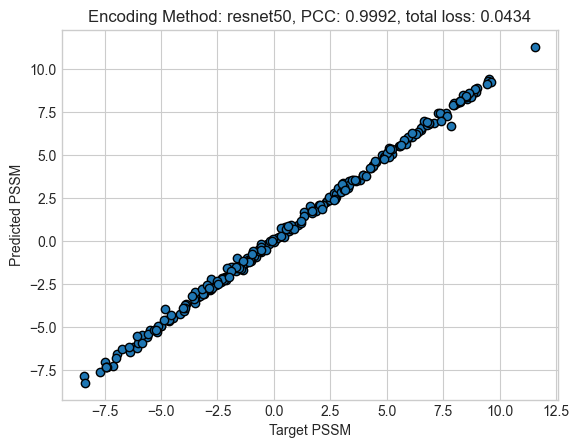

In [ ]:
pcc = pearsonr(evaluation_score, np.array(predictions).flatten())
print("PCC: ", pcc[0])

plt.figure()
plt.style.use('seaborn-whitegrid');
plt.scatter(evaluation_score, predictions, edgecolors='black');
plt.xlabel('Target PSSM');
plt.ylabel('Predicted PSSM');
plt.title(f'Encoding Method: {encoding_method}, PCC: {pcc[0]:.4f}, total loss: {total_loss:.4f}');
plt.savefig(f'./evaluation_result/{network_type}/{encoding_method}_evaluation_scatter.png')